In [1]:
!pip install prophet
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore
import logging

In [11]:
logging.getLogger('prophet').setLevel(logging.ERROR)

def getDataFromFile():
    df = pd.read_csv("AirtrafficA4.csv")
    df.columns = df.columns.str.strip()

    cols_to_convert = [
        'TOTAL DEPARTURES',
        'HOURS FLOWN',
        'KILOMETRE FLOWN',
        'PASSENGERS CARRIED',
        'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',
        'FREIGHT CARRIED (IN TONNE)',
        'MAIL CARRIED (IN TONNE)'
    ]

    df.replace('', pd.NA, inplace=True)
    df.dropna(subset=cols_to_convert, inplace=True)

    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col].replace(',', '', regex=True), errors='coerce')

    df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].str[:3], format='%Y-%b')
    df.set_index('DATE', inplace=True)
    df.sort_index(inplace=True)

    drop_params = ['AIRLINE', 'YEAR', "MONTH"]
    df.drop(drop_params, axis=1, inplace=True)

    def smooth_outliers(data, threshold=2.5, window=6):
        smoothed_data = data.copy()
        for col in data.columns:
            z_scores = np.abs(zscore(data[col].dropna()))
            outliers = z_scores > threshold
            smoothed_data.loc[outliers, col] = smoothed_data[col].rolling(
                window=window,
                min_periods=1,
                center=True
            ).mean()
        return smoothed_data

    df = smooth_outliers(df)
    df = df.interpolate(method='cubic', limit_direction='both')
    df.fillna(df.ewm(span=12).mean(), inplace=True)

    return df

In [12]:
def prepare_prophet_data(df):
    df_prophet = df.reset_index()

    prophet_df = pd.DataFrame()
    prophet_df['ds'] = df_prophet['DATE']
    prophet_df['y'] = df_prophet['PASSENGERS CARRIED']

    regressor_columns = [
        'TOTAL DEPARTURES',
        'HOURS FLOWN',
        'KILOMETRE FLOWN',
        'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',
        'FREIGHT CARRIED (IN TONNE)',
        'MAIL CARRIED (IN TONNE)'
    ]

    for col in regressor_columns:
        prophet_df[col] = df_prophet[col]

    return prophet_df

In [13]:
def create_global_prophet_model(df_prophet, training_cutoff='2023-09-01'):
    train_df = df_prophet[df_prophet['ds'] < training_cutoff].copy()
    test_df = df_prophet[df_prophet['ds'] >= training_cutoff].copy()

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        interval_width=0.85,  # Narrower interval width
        changepoint_prior_scale=0.05,  # Less flexible trend changes
        seasonality_prior_scale=10,  # Less flexible seasonality
        holidays_prior_scale=5,  # Less flexible holiday effects
        n_changepoints=20,  # Fewer changepoints
        changepoint_range=0.9  # Less range for changepoints
    )

    # Add custom seasonalities
    model.add_seasonality(
        name='quarterly',
        period=91.25,
        fourier_order=5
    )

    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=3
    )

    regressor_columns = [
        'TOTAL DEPARTURES',
        'HOURS FLOWN',
        'KILOMETRE FLOWN',
        'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',
        'FREIGHT CARRIED (IN TONNE)',
        'MAIL CARRIED (IN TONNE)'
    ]

    for col in regressor_columns:
        model.add_regressor(col, mode='multiplicative')

    model.fit(train_df)

    # Perform cross-validation
    df_cv = cross_validation(
        model,
        initial='730 days',
        period='180 days',
        horizon='365 days',
        parallel="threads"
    )

    cv_metrics = performance_metrics(df_cv)
    print("\nCross Validation Metrics:")
    print(cv_metrics[['horizon', 'mape', 'rmse', 'mae']].tail())

    return model, train_df, test_df

In [19]:
def make_future_predictions(model, df_prophet, periods=12):
    future = model.make_future_dataframe(periods=periods, freq='M')

    regressor_columns = [
        'TOTAL DEPARTURES',
        'HOURS FLOWN',
        'KILOMETRE FLOWN',
        'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',
        'FREIGHT CARRIED (IN TONNE)',
        'MAIL CARRIED (IN TONNE)'
    ]

    for col in regressor_columns:
        future[col] = df_prophet[col].ewm(span=12).mean().iloc[-1]
        trend_last_year = (df_prophet[col].iloc[-1] - df_prophet[col].iloc[-12]) / 12
        future.loc[len(df_prophet):, col] += np.arange(1, periods + 1) * trend_last_year

    return future

def evaluate_predictions(predictions, actuals):
    metrics = {
        'MAE': mean_absolute_error(actuals, predictions),
        'RMSE': np.sqrt(mean_squared_error(actuals, predictions)),
        'MAPE': np.mean(np.abs((actuals - predictions) / actuals)) * 100
    }
    return metrics

In [20]:
def run_global_prophet_analysis():
    df = getDataFromFile()
    df_prophet = prepare_prophet_data(df)

    model, train_df, test_df = create_global_prophet_model(df_prophet)

    future = make_future_predictions(model, df_prophet)
    forecast = model.predict(future)

    predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

    metrics = {}
    if len(test_df) > 0:
        actuals = test_df['y'].values
        predicted = predictions['yhat'].values[:len(actuals)]
        metrics = evaluate_predictions(predicted, actuals)

        print("\nValidation Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.2f}")
    else:
        print("No test data available for validation metrics.")

    return model, forecast, predictions, metrics

def plot_prophet_results(model, forecast):
    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)
    return fig1, fig2

DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/udsn2r55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/ww9u7mtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97483', 'data', 'file=/tmp/tmp50kq398u/udsn2r55.json', 'init=/tmp/tmp50kq398u/ww9u7mtg.json', 'output', 'file=/tmp/tmp50kq398u/prophet_model2q56iws8/prophet_model-20241028175520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/8axd1_5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/x_fn79o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/obfz98g1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50kq398u/9xva


Cross Validation Metrics:
     horizon      mape          rmse           mae
144 359 days  0.502225  2.656252e+06  1.725134e+06
145 360 days  1.016169  7.792076e+06  3.473931e+06
146 361 days  1.001802  7.778144e+06  3.408519e+06
147 364 days  0.977690  7.762341e+06  3.326785e+06
148 365 days  0.920869  7.712375e+06  3.137150e+06
No test data available for validation metrics.

Predictions for next 12 months:
2023-08: 7,756,598 passengers
2023-09: 7,562,098 passengers
2023-10: 8,386,540 passengers
2023-11: 8,781,196 passengers
2023-12: 8,352,657 passengers
2024-01: 8,790,761 passengers
2024-02: 8,940,012 passengers
2024-03: 9,360,905 passengers
2024-04: 9,689,024 passengers
2024-05: 9,978,292 passengers
2024-06: 9,753,609 passengers
2024-07: 10,032,240 passengers


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


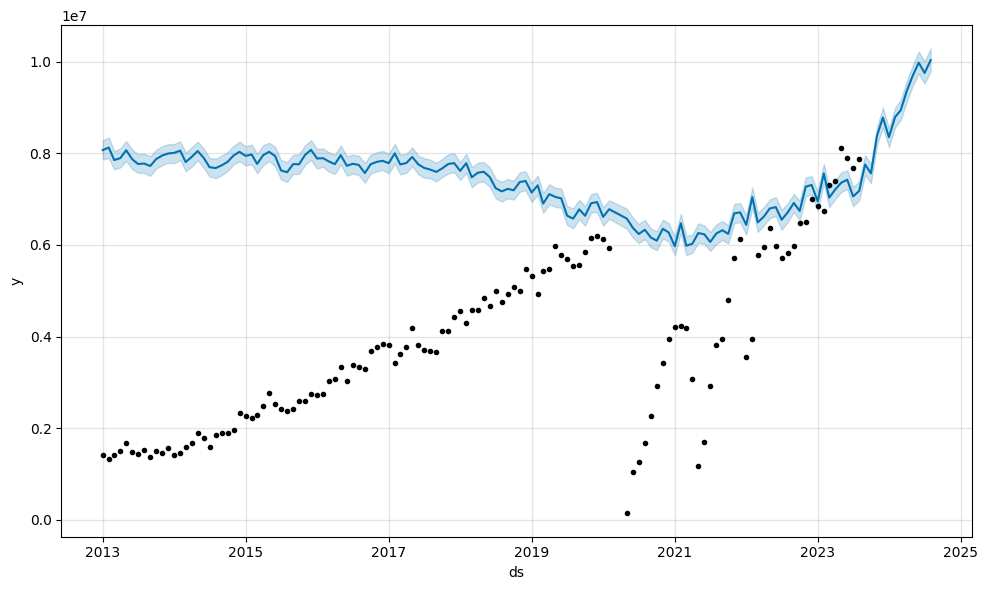

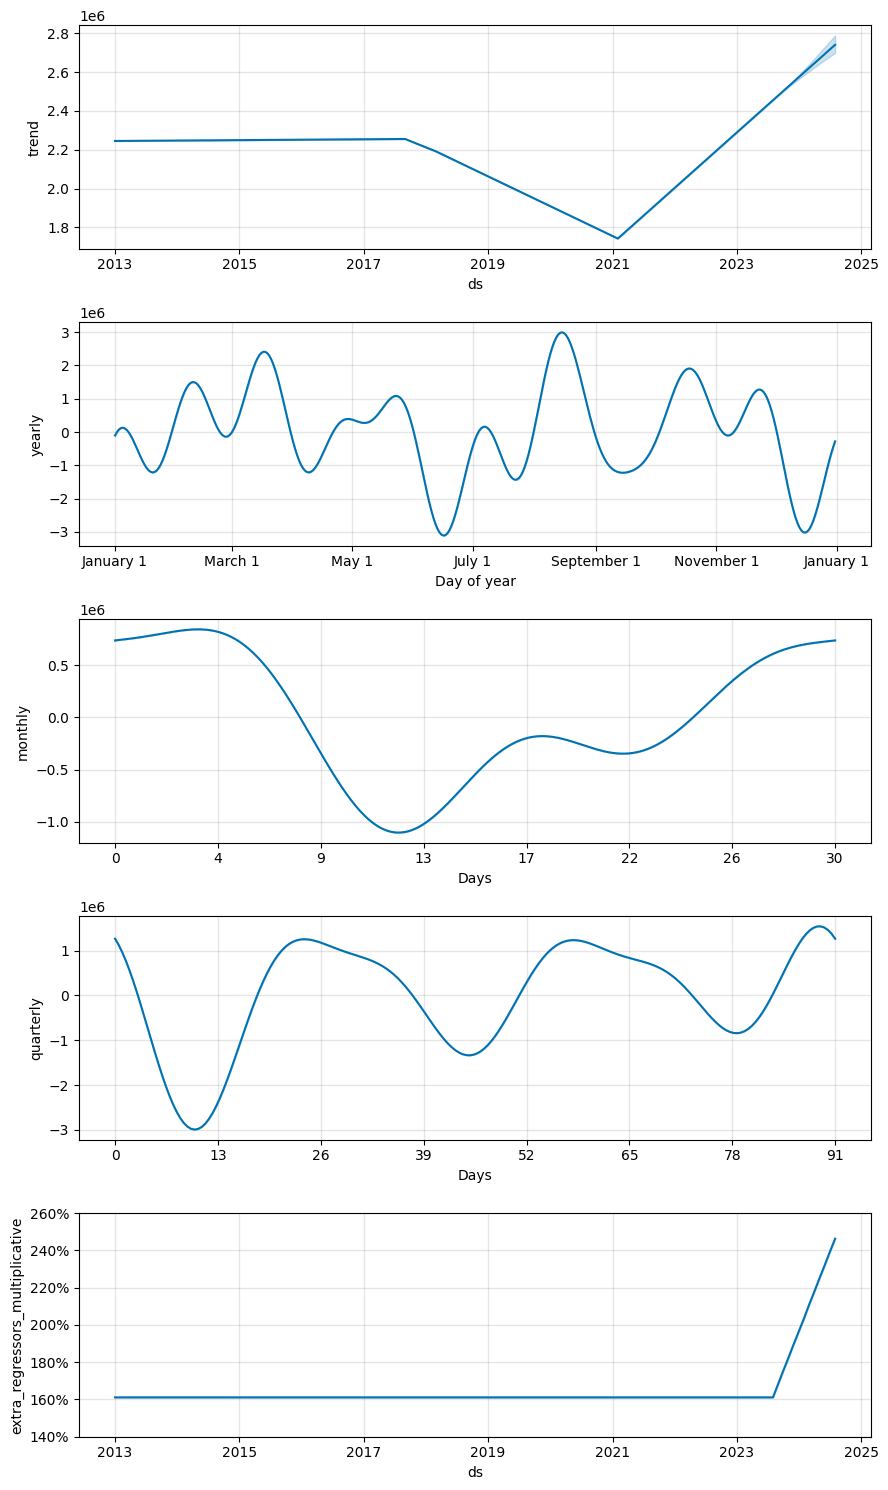

In [21]:
model, forecast, predictions, metrics = run_global_prophet_analysis()

print("\nPredictions for next 12 months:")
for index, row in predictions.iterrows():
    print(f"{row['ds'].strftime('%Y-%m')}: {int(row['yhat']):,} passengers")

forecast_plot, component_plot = plot_prophet_results(model, forecast)
predictions.to_csv('prophet_predictions.csv', index=False)